In [1]:
import numpy as np
import pandas as pd
import torch.utils.data as data
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

from keras import layers

from matplotlib import pyplot as plt

import medmnist

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'dermamnist'
download = True

class TrainingConfig:
    EPOCHS:        int = 50
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001

In [4]:
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
print(info)

print("\n'task': 'binary-class', 'label': {'0': 'malignant', '1': 'normal, benign'}, 'n_channels': 1, 'n_samples': {'train': 546, 'val': 78, 'test': 156}'")

{'python_class': 'DermaMNIST', 'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.', 'url': 'https://zenodo.org/records/10519652/files/dermamnist.npz?download=1', 'MD5': '0744692d530f8e62ec473284d019b0c7', 'url_64': 'https://zenodo.org/records/10519652/files/dermamnist_64.npz?download=1', 'MD5_64': 'b70a2f5635c6199aeaa28c31d7202e1f', 'url_128': 'https://zenodo.org/records/10519652/files/dermamnist_128.npz?download=1', 'MD5_128': '2defd784463fa5243564e855ed717de1', 'url_224': 'https://zenodo.org/records/10519652/files/dermamnist_224.npz?download=1', 'MD5_224': '8974907d8e169bef5f5b96bc506ae45d', 'task': 'multi-class', 'la

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=TrainingConfig.BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*TrainingConfig.BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*TrainingConfig.BATCH_SIZE, shuffle=False)

In [7]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(val_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: C:\Users\geo_s\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapo

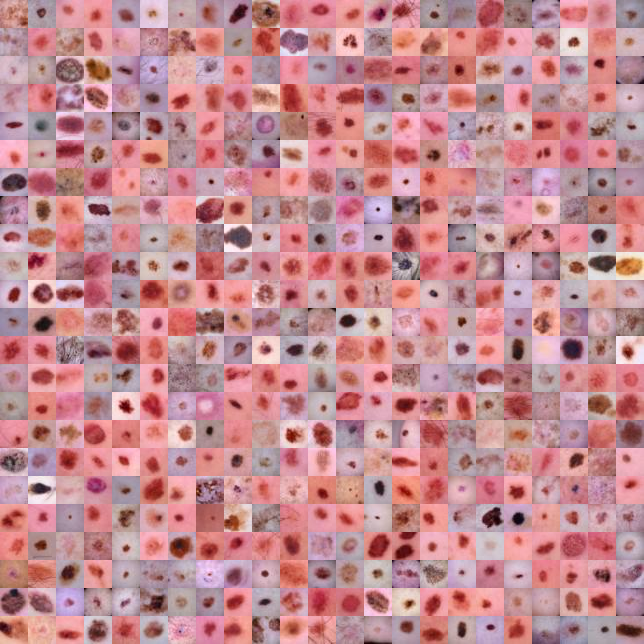

In [8]:
train_dataset.montage(length=23)

In [9]:
data_augmentation = Sequential(
  [
    Input(shape=(28, 28, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(.07),
    layers.RandomZoom(.1)
  ]
)

In [10]:
def build_model(hp):
    model = Sequential(name="modelo_cnn")

    #CANTIDAD DE FILTROS
    hp_filters_1 = hp.Choice('filters_block1', values=[16, 32, 64])
    hp_filters_2 = hp.Choice('filters_block2', values=[16, 32, 64, 128])
    
    #NÚMERO DE NEURONAS EN CAPA DENSA
    hp_units = hp.Int('dense_units', min_value=256, max_value=512, step=128)
    
    #TAZA DE APRENDIZAJE
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    #TAZA DE DROPOUT
    hp_dropout_dense = hp.Float('dropout_dense', min_value=0.2, max_value=0.4, step=0.1)

    #OPTIMIZADORES
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd', 'adagrad'])

    #LLAMAR AL OPTIMIZADOR Y DARLE EL LR
    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    else:
        optimizer = Adagrad(learning_rate=hp_learning_rate)

    #CONSTRUYENDO MODELO
    model.add(data_augmentation)
    model.add(Conv2D(filters=hp_filters_1, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=hp_filters_1, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
    model.add(Dropout(0.25)) 
    
    model.add(Conv2D(filters=hp_filters_2, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=hp_filters_2, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(rate=hp_dropout_dense))
    model.add(Dense(1, activation='sigmoid'))
   
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [11]:
tuner = kt.GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,  #NUM DE CONFIGURACIONES DIFERENTES
    executions_per_trial=1, #CANT DE VECES QUE SE ENTRENA CADA CONFIG
    directory='keras_tuner_dir',
    project_name='breast_cancer_optimization',
    overwrite=True
)

In [12]:
tuner.search_space_summary()
stop_early = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
reduce_lr = ReduceLROnPlateau( monitor = 'val_loss', factor = 0.1, patience = 8, min_lr = 0.00001, verbose = 2, mode='min' )

Search space summary
Default search space size: 6
filters_block1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
filters_block2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_dense (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd', 'adagrad'], 'ordered': False}


In [13]:
X_train = train_dataset.imgs
y_train = train_dataset.labels

X_val = val_dataset.imgs
y_val = val_dataset.labels

X_test = test_dataset.imgs
y_test = test_dataset.labels

In [14]:
print(y_train.shape, X_train.shape)
print("===================")
print(y_val.shape, X_val.shape)
print("===================")
print(y_test.shape, X_test.shape)

(7007, 1) (7007, 28, 28, 3)
(1003, 1) (1003, 28, 28, 3)
(2005, 1) (2005, 28, 28, 3)


In [16]:
print("Se inicia la búsqueda de los mejores hp")
hist = tuner.search(X_train,
             y_train,
             epochs=TrainingConfig.EPOCHS,
             validation_data=(X_val, y_val),
             callbacks=[reduce_lr, stop_early]
            )

Trial 6 Complete [00h 02m 49s]
val_accuracy: 0.05184446647763252

Best val_accuracy So Far: 0.05184446647763252
Total elapsed time: 00h 20m 04s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
16                |16                |filters_block1
16                |16                |filters_block2
256               |256               |dense_units
0.01              |0.01              |learning_rate
0.3               |0.2               |dropout_dense
sgd               |adam              |optimizer

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.0512 - loss: -7869824000.0000 - val_accuracy: 0.0518 - val_loss: -22.7786 - learning_rate: 0.0100
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0512 - loss: -33.8573 - val_accuracy: 0.0518 - val_loss: -44.9386 - learning_rate: 0.0100
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0512 - loss: -56.0492 - val_accuracy: 0.0518 - val_loss: -67.0966 - learning_r

KeyboardInterrupt: 